<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Projection methods

Build 3D dataset:

In [0]:
np.random.seed(259)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m,3))

In [0]:
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) /2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) /2
X[:, 2] = X[:,0] * w1 + X[:,1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

In [0]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [0]:
m,n = X.shape
S = np.zeros(X_centered.shape)
S[:n , :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [0]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

## PCA using Scikit-Learn

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[-0.67691283, -0.26765032],
       [ 0.92163698,  0.4578776 ],
       [ 1.21555767,  0.01837351],
       [-1.13761569,  0.11180205],
       [-0.62733185, -0.27874387]])

In [10]:
X2D_using_svd[:5]

array([[-0.67691283, -0.26765032],
       [ 0.92163698,  0.4578776 ],
       [ 1.21555767,  0.01837351],
       [-1.13761569,  0.11180205],
       [-0.62733185, -0.27874387]])

In [11]:
np.allclose(X2D, X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [0]:
X3D_inv = pca.inverse_transform(X2D)

There was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points

In [13]:
np.allclose(X3D_inv, X)

False

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.009992311287545077

The inverse transform in the SVD approach looks like this:

In [0]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])


The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
print(pca.components_,'\n', Vt[:2])

[[ 0.93969637  0.29546354  0.17225573]
 [ 0.33504492 -0.89640177 -0.29018746]] 
 [[ 0.93969637  0.29546354  0.17225573]
 [ 0.33504492 -0.89640177 -0.29018746]]


In [18]:
pca.explained_variance_ratio_

array([0.91008001, 0.08092672])

In [19]:
1 - pca.explained_variance_ratio_.sum()

0.008993267296064311


Express the plane as a function of x and y.

In [0]:
axes = [-1.9, 1.9, -1.8, 1.8, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

In [0]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


Plot the 3D dataset, the plane and the projections on that plane.

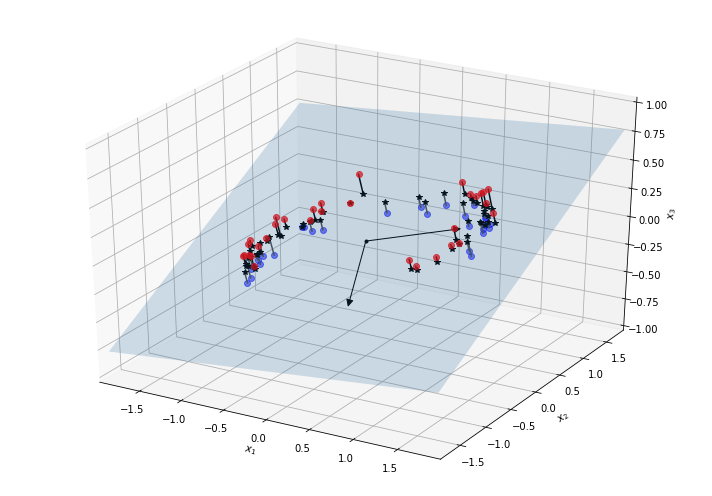

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection = '3d')

X3D_above = X[X[:, 2] > X3D_inv[:,2 ]]
X3D_below = X[X[:, 2] <= X3D_inv[:,2 ]]

ax.plot(X3D_below[:,0], X3D_below[:,1], X3D_below[:,2], 'bo', alpha = 0.5)


ax.plot_surface(x1, x2, z , alpha= 0.2)
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0,0]] , [0,C[0,1]], [0, C[0, 2]] , mutation_scale = 15, arrowstyle = "-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1,0]] , [0,C[1,1]], [0, C[1, 2]] , mutation_scale = 15, arrowstyle = "-|>", color="k"))
ax.plot([0], [0], [0], "k.")


for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k*")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro", alpha = 0.7)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")


plt.tight_layout()
plt.show()

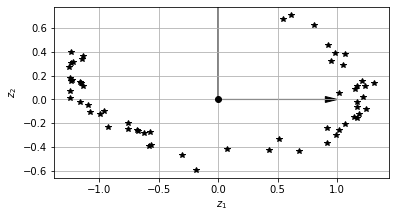

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')

ax.plot(X2D[:,0],X2D[:,1],'k*')
ax.plot([0],[0], 'ko')
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.grid(True)

## Manifold Learning

Swiss roll:

In [0]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples= 1000, noise = 0.2, random_state=259)

In [0]:
axes = [X[:,0].min() - 1, X[:,0].max() + 1, X[:,1].min() - 1, X[:,1].max() + 1, X[:,2].min() - 1, X[:,2].max() + 1]

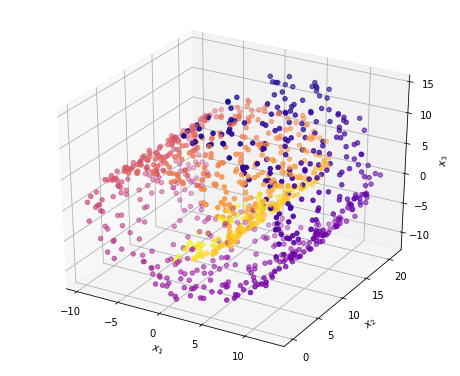

In [26]:
fig = plt.figure(figsize=(8,6.66))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap = plt.cm.plasma_r)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")

plt.show()

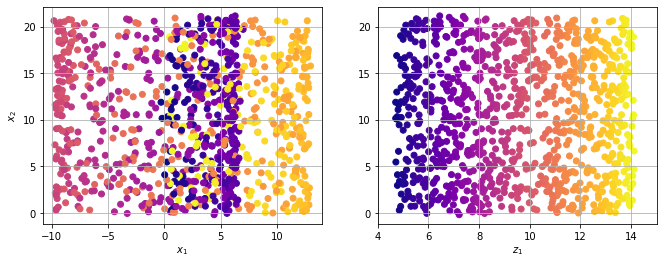

In [27]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap = plt.cm.plasma)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap = plt.cm.plasma)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

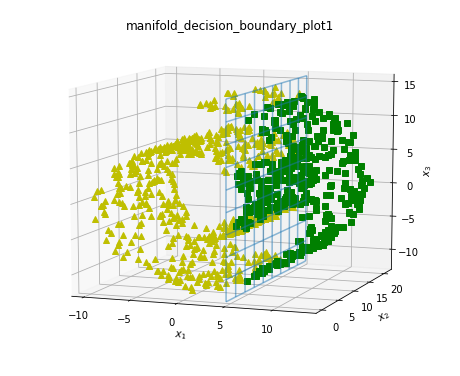

In [28]:
from matplotlib import gridspec

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(8, 6.66))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title("manifold_decision_boundary_plot1")
plt.show()

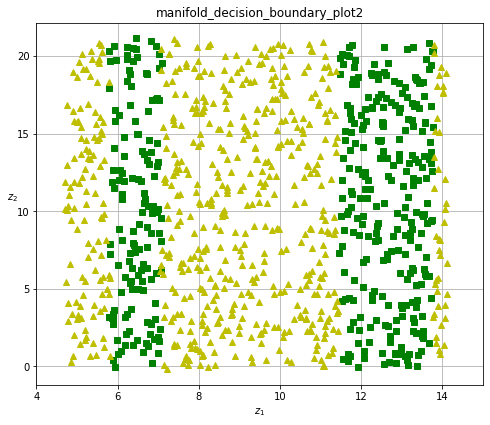

In [29]:
fig = plt.figure(figsize=(8, 6.66))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid(True)
plt.title("manifold_decision_boundary_plot2")
plt.show()

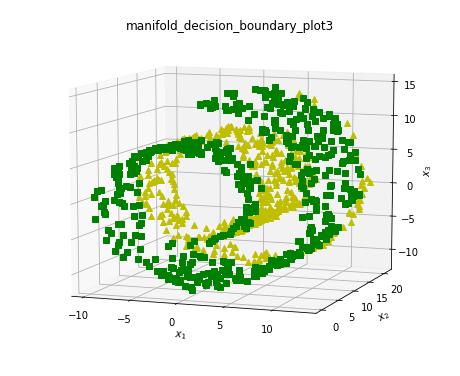

In [30]:
fig = plt.figure(figsize=(8, 6.66))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title("manifold_decision_boundary_plot3")
plt.show()

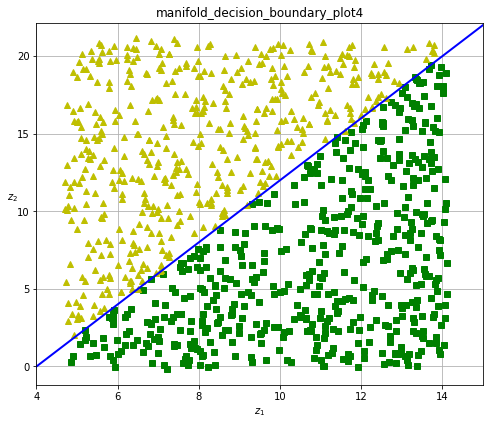

In [31]:
fig = plt.figure(figsize=(8, 6.66))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid(True)
plt.title("manifold_decision_boundary_plot4")
plt.show()

## PCA

In [0]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(259)
X = np.random.randn(m,2) / 10
X = X.dot(np.array([[stretch, 0],[0,1]])) # stretch
X = X.dot([ [np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)] ]) # rotate

In [0]:
u1 = np.array([ np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([ np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1,1))
X_proj2 = X.dot(u2.reshape(-1,1))
X_proj3 = X.dot(u3.reshape(-1,1))

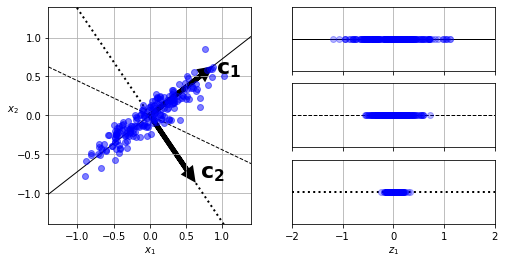

In [34]:
plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

## MNIST Compression

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(np.int64)

In [0]:
from sklearn.model_selection import train_test_split
X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [0]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [38]:
d

154

In [0]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [40]:
pca.n_components_

154

In [41]:
np.sum(pca.explained_variance_ratio_)

0.9504041148560963

In [0]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [0]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

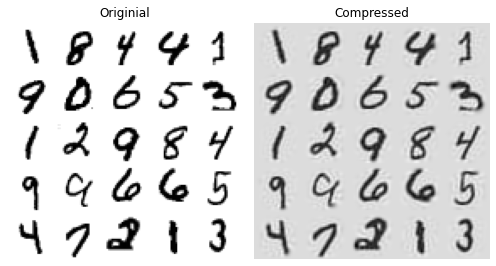

In [44]:
plt.figure(figsize = (7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Originial")
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed")
plt.tight_layout()
plt.show()

In [0]:
X_reduced_pca = X_reduced

## Incremental PCA

In [46]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
print("Done")
X_reduced = inc_pca.transform(X_train)

....................................................................................................Done


In [0]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

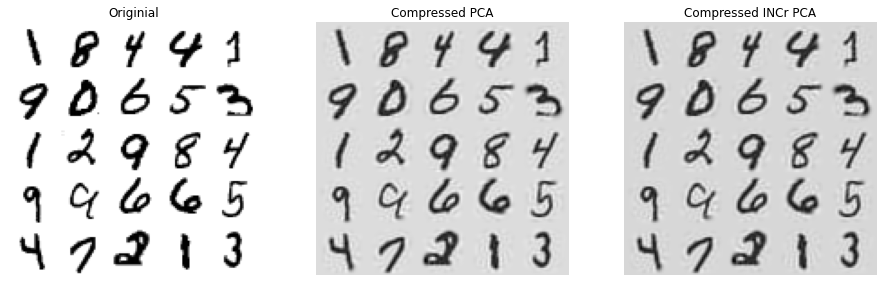

In [48]:
plt.figure(figsize = (13,4))
plt.subplot(131)
plot_digits(X_train[::2100])
plt.title("Originial")
plt.subplot(132)
plot_digits(X_recovered[::2100])
plt.title("Compressed PCA")
plt.subplot(133)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed INCr PCA")
plt.tight_layout()
plt.show()

In [0]:
X_reduced_inc_pca = X_reduced

In [50]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [51]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using memmap()

Let's create the memmap() structure and copy the MNIST data into it. This would typically be done by a first program:

In [0]:
filename = 'my_mnist.data'
m,n = X_train.shape

X_mm = np.memmap(filename, dtype = 'float32', mode = 'write', shape = (m,n))

X_mm[:] = X_train

In [0]:
del X_mm

Another program would load the data and use it for training

In [54]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size = batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [0]:
rnd_pca = PCA(n_components = 154, svd_solver='randomized', random_state = 259)
X_reduced = rnd_pca.fit_transform(X_train)

In [0]:
del X_mm

## Time Complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [0]:
import time

In [58]:
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.1 seconds
    IncrementalPCA: 20.3 seconds
    PCA: 2.1 seconds
n_components = 10
    PCA: 2.5 seconds
    IncrementalPCA: 21.4 seconds
    PCA: 2.4 seconds
n_components = 154
    PCA: 7.9 seconds
    IncrementalPCA: 31.9 seconds
    PCA: 7.8 seconds


In [0]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

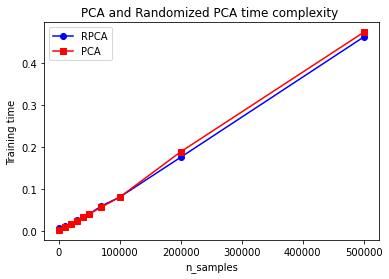

In [60]:
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

let's compare their performance on datasets of 2,000 instances with various numbers of features

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

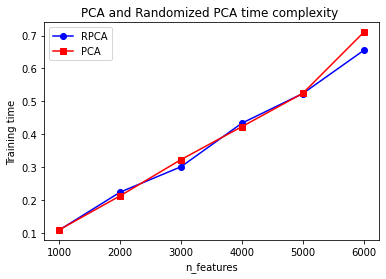

In [61]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=259, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## Kernel PCA

In [0]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=259)

In [0]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [0]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

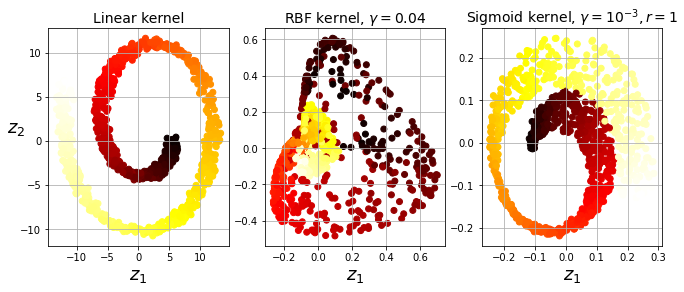

In [65]:
y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

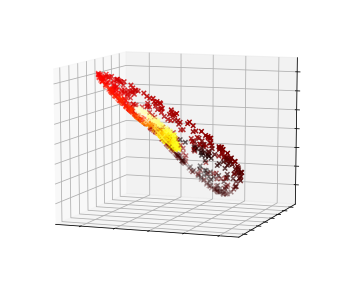

In [66]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

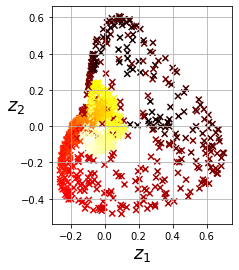

In [67]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)


In [0]:
X, t = make_swiss_roll(n_samples=10000, noise=0.2, random_state=41)

In [0]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, random_state = 259)
x_reduced = lle.fit_transform(X)

In [70]:
X_reduced.shape

(1000, 2)

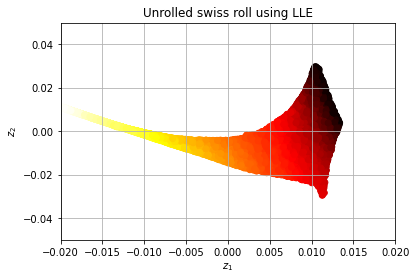

In [72]:
plt.title("Unrolled swiss roll using LLE")
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.axis([-0.02, 0.02, -0.05, 0.05])
plt.grid(True)
plt.show()